- 로이터 뉴스 기사
- 46개 주제(레이블) => 다중분류
- 단어의 개수는 10000개로 제한
- 텍스트 데이터를 벡터로 변환 (원핫인코딩)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 데이터 로드 및 전처리

In [2]:
from keras.datasets import reuters

(x_train, y_train), (x_test, y_test) = reuters.load_data()
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

8982
2246
8982
2246


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# Tokenizer를 사용하여 원-핫 인코딩 수행
tokenizer = Tokenizer(num_words=10000)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

# 레이블 데이터들을 범주형 형태로 변환
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("훈련 데이터 크기:", x_train.shape)
print("테스트 데이터 크기:", x_test.shape)

훈련 데이터 크기: (8982, 10000)
테스트 데이터 크기: (2246, 10000)


# 2. 모델 구성 및 컴파일

- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델

In [7]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Input(shape=(10000,)))  # 입력 형태 지정

# 첫 번째 Dense 레이어
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())  # BatchNormalization 적용
model.add(layers.Dropout(0.5))          # Dropout 적용

# 두 번째 Dense 레이어
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())  # BatchNormalization 적용
model.add(layers.Dropout(0.5))          # Dropout 적용

# 출력 레이어
model.add(layers.Dense(46, activation='softmax'))  # 46개의 출력 클래스 (Reuters 데이터셋의 클래스 수)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # 다중 클래스 분류 문제에 적합한 손실 함수
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       5,120,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 46)                  │          11,822 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,266,734 (20.09 MB)

 Trainable params: 5,265,198 (20.09 MB)

 Non-trainable params: 1,536 (6.00 KB)

# 3. 모델 학습

- ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint와 EarlyStopping 콜백 함수 설정
checkpoint_cb = ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1) # verbose=1 언제 저장되는지 보여줌
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.25,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5202 - loss: 2.5024
Epoch 1: val_loss improved from inf to 1.27203, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.5208 - loss: 2.4993 - val_accuracy: 0.7591 - val_loss: 1.2720
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8111 - loss: 0.8466
Epoch 2: val_loss improved from 1.27203 to 0.94395, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8112 - loss: 0.8466 - val_accuracy: 0.8032 - val_loss: 0.9440
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8755 - loss: 0.5374
Epoch 3: val_loss did not improve from 0.94395
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8755 - loss: 0.5375 - val_accuracy: 0.8134 - val_loss: 0.9694
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9155 - loss: 0.3299
Epoch 4: val_loss did not improve from 0.94395
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 85

<ipython-input-11-ef4da0309378>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


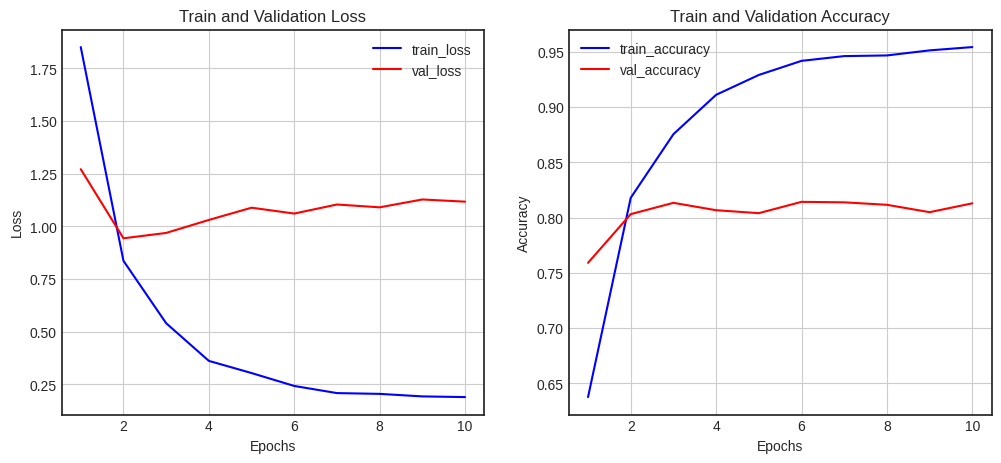

In [11]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

# 4. 모델 평가

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7803 - loss: 0.9750
Test Loss: 0.9826272130012512
Test Accuracy: 0.7831701040267944
